# Datasets

## Stock tweets

In [1]:
# Imports
import pandas as pd
import os
import flair
import torch
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.utils import shuffle
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from simpletransformers.classification import ClassificationModel
import logging
import sklearn
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from datetime import datetime

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.utils import resample # downsample etc

from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import KFold,cross_val_score

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC

In [2]:
# nlp libs
import re

import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import nltk
nltk.download('stopwords')
nltk.download('punkt') # for stemming
nltk.download('wordnet') # for lemmatizing
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# https://www.kaggle.com/utkarshxy/stock-markettweets-lexicon-data - 9917 labelled tweets
stock_data_file = os.getcwd() + "\\Data\\stock_data.csv"
stock_data = pd.read_csv(stock_data_file)
stock_data= stock_data.rename(columns=str.lower)
stock_data.dropna(inplace=True)
print(stock_data)

# https://www.kaggle.com/yash612/stockmarket-sentiment-dataset - 5791 labelled tweets
tweets_data_file = os.getcwd() + "\\Data\\tweets_labelled.csv"
tweets_data = pd.read_csv(tweets_data_file, delimiter=';')
tweets_data.drop(columns=['id','created_at'], inplace=True)
tweets_data.dropna(inplace=True)
print(tweets_data)

# combine
dataset_frames = [stock_data, tweets_data]
dataset_frames_names = ["stock_data", "tweets_data"]
combined_df = result = pd.concat(dataset_frames)

                                                   text  sentiment
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2     user I'd be afraid to short AMZN - they are lo...          1
3                                     MNTA Over 12.00            1
4                                      OI  Over 21.37            1
...                                                 ...        ...
5786  Industry body CII said #discoms are likely to ...         -1
5787  #Gold prices slip below Rs 46,000 as #investor...         -1
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1
5790  #Sensex, #Nifty climb off day's highs, still u...          1

[5791 rows x 2 columns]
                                                   text sentiment
0     RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...  positive
1     #SriLanka surcharge on fuel remov

### Definitions

In [16]:
max_features = 10000
def sentiment_to_label(sentiment):
    if sentiment == "positive" or sentiment == 1:
        return 1
    elif sentiment == "negative" or sentiment == -1 or sentiment == 0:
        return 0
    else:
        return pd.NA

porter_stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

lemmer=WordNetLemmatizer()
def lemmatizing_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [lemmer.lemmatize(word) for word in words]
    return words

# From Lab
df_new = combined_df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text

    return text

### Cleaning

In [17]:
df_new['text'] = df_new['text'].apply(clean_text)
df_new['text'] = df_new['text'].str.replace('\d+', '')
df_new['sentiment'] = df_new['sentiment'].apply(sentiment_to_label)
df_new['sentiment'] = pd.to_numeric(df_new['sentiment'])
df_new.dropna(inplace=True)
df_new = shuffle(df_new)
df_new.head()

C:\Users\JMARCO~1\AppData\Local\Temp/ipykernel_16944/1471953282.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_new['text'] = df_new['text'].str.replace('\d+', '')


,text,sentiment
954,,1.0
3405,ssys statement cash flow still secret mention ...,0.0
616,st watch list lien bit volume full day average,1.0
4164,user idea whats going im taking profits shar...,1.0
4828,hit stops aap longs yesterday falling knife,0.0


1.0    4213
0.0    2454
Name: sentiment, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'sentiment')

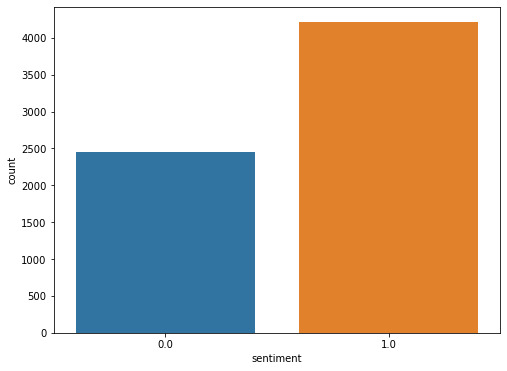

In [18]:
print(df_new['sentiment'].value_counts())
rcParams['figure.figsize'] = 8, 6
sns.countplot(df_new.sentiment)
plt.xlabel('sentiment')

In [19]:
X = df_new['text']
y = [int(x) for x in df_new['sentiment']]

count_vect = CountVectorizer(tokenizer=stemming_tokenizer, stop_words='english', max_features=max_features)
X_binary_counts = count_vect.fit_transform(X)
print("X_binary_counts.shape", X_binary_counts.shape)
print("X_binary_counts[20]:\n%s" %X_binary_counts[20])
print("X_binary_counts.toarray()[0]", X_binary_counts.toarray()[0])
print("len(X_binary_counts.toarray()[0])", len(X_binary_counts.toarray()[0]))
print("max(X_binary_counts.toarray()[0])", len(max(X_binary_counts.toarray(), key=len)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

X_binary_counts.shape (6667, 9726)
X_binary_counts[20]:
  (0, 7944)	1
  (0, 8040)	1
  (0, 9395)	1
  (0, 6356)	1
  (0, 2023)	1
  (0, 2293)	1
  (0, 3297)	1
  (0, 4350)	1
  (0, 4752)	1
  (0, 5768)	1
  (0, 5513)	1
  (0, 5871)	1
  (0, 7403)	1
  (0, 7392)	1
  (0, 8995)	1
X_binary_counts.toarray()[0] [0 0 0 ... 0 0 0]
len(X_binary_counts.toarray()[0]) 9726
max(X_binary_counts.toarray()[0]) 9726


##### TF-IDF

In [23]:
tfidf_transformer = TfidfTransformer() 

X_tfidf_binary = tfidf_transformer.fit_transform(X_binary_counts)
print("X_tfidf_binary.shape", X_tfidf_binary.shape)
X_all_binary = X_tfidf_binary.toarray()
X_all_binary

X_tfidf_binary.shape (6667, 9726)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Smote Oversampling

In [24]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_all_binary, y)
print('SMOTE oversamples dataset shape %s' % Counter(y_res))
print("X_res.shape", X_res.shape)
X_all_binary = X_res
y = [int(x) for x in y_res]

SMOTE oversamples dataset shape Counter({1: 4213, 0: 4213})
X_res.shape (8426, 9726)


##### CVM Best Model - Train Tweet Classifier 

In [25]:
clf = SVC(C=50, gamma=1, random_state=42).fit(X_all_binary, y)

## Bitcoin Tweets

Kash. (2021-10-16). Bitcoin Tweets, 1. Retrieved 2022-03-06 from https://www.kaggle.com/kaushiksuresh147/bitcoin-tweets.

In [4]:
import zipfile
import os
import pandas as pd
cwd = os.getcwd()
zipped_file_location = cwd = os.getcwd() + "\\Data\\bitcoin_tweets.zip"
unzipped_file_location = os.getcwd() + "\\Data\\"
tweets_file =  os.getcwd() + "\\Data\\bitcoin_tweets.csv"

df_tweets = None
if not os.path.isfile(unzipped_file_location + 'formatted_bitcoin_tweets.csv'):

    # Extract ZIP
    with zipfile.ZipFile(zipped_file_location, 'r') as zip_ref:
        zip_ref.extractall(unzipped_file_location)

    # Read from title file
    df_tweets = pd.read_csv(tweets_file)

    # Remove temp files 
    os.remove(os.path.join(unzipped_file_location,tweets_file))

    # Convert
    df_tweets["date"] = pd.to_datetime(df_tweets["date"], errors="coerce", utc=True)
    df_tweets["date"] = df_tweets["date"].dt.date
    df_tweets = df_tweets.set_index(pd.DatetimeIndex(df_tweets['date']))
    df_tweets.dropna(inplace=True)

    # Remove unrequired columns
    df_tweets = df_tweets[['text']]

    # Save 
    #compression_opts = dict(method='zip', archive_name='formatted_bitcoin_news.zip') 
    df_tweets.to_csv(unzipped_file_location + 'formatted_bitcoin_tweets.csv')
else:
    df_tweets = pd.read_csv(unzipped_file_location + 'formatted_bitcoin_tweets.csv')
    df_tweets = df_tweets.set_index(pd.DatetimeIndex(df_tweets['date']))
    df_tweets = df_tweets[['text']]

In [21]:
df_tweets

,text
date,
2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...
2021-02-10,This network is secured by 9 508 nodes as of t...
2021-02-10,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...
2021-02-10,&lt;'fire' &amp; 'man'&gt;\n#Bitcoin #Crypto #...
2021-02-10,.@Tesla’s #bitcoin investment is revolutionary...
...,...
2022-03-02,#btc testing testing testing 👀🚀
2022-03-02,This project is give us a very Good profit. I ...
2022-03-02,👑Psycho Ape is an exclusive collection of uniq...


<AxesSubplot:xlabel='date'>

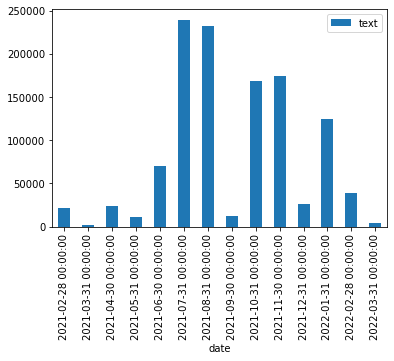

In [22]:
df_tweets.groupby(pd.Grouper(freq="M")).count().plot(kind="bar")

### Cleaning

In [36]:
df_tweets['text'] = df_tweets['text'].apply(clean_text)
df_tweets['text'] = df_tweets['text'].str.replace('\d+', '')
df_tweets.head()

C:\Users\JMARCO~1\AppData\Local\Temp/ipykernel_16944/3339991055.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets['text'] = df_tweets['text'].str.replace('\d+', '')


,text
date,
2021-02-10,blue ridge bank shares halted nyse #bitcoin at...
2021-02-10,network secured nodes today soon biggest bea...
2021-02-10,trade #crypto #binance enjoy #cashback tradin...
2021-02-10,lt fire amp mangt #bitcoin #crypto #btc https ...
2021-02-10,teslas #bitcoin investment revolutionary #cryp...


### Tagging

In [1]:
import zipfile
import os
import pandas as pd
cwd = os.getcwd()
unzipped_file_location = os.getcwd() + "\\Data\\"

# WARNING - TAKES 24 HOURS TO COMPLETE!!!
if not os.path.isfile(unzipped_file_location + 'formatted_bitcoin_tweets_labelled.csv'):
    # we need to chunk as we don't have nearly enough memory to convert entire sparse matrix to array!
    n = 1000    #chunk row size
    bitcoin_tweet_sentiment_predictions = []
    list_df = np.array_split(df_tweets, n)
    for idx, df_slice in enumerate(list_df):
        print("Processing chunk " + str(idx+1) + "/" +str(n))
        slice_binary_counts = count_vect.transform(df_slice['text'])
        slice_tfidf_binary = tfidf_transformer.transform(slice_binary_counts)
        slice_binary_arr = slice_tfidf_binary.toarray()
        bitcoin_tweet_sentiment_predictions.extend(clf.predict(slice_binary_arr))

    df_tweets['sentiment'] = bitcoin_tweet_sentiment_predictions
    df_tweets['sentiment'] = df_tweets['sentiment'].apply(sentiment_to_label)
    df_tweets['sentiment'] = pd.to_numeric(df_tweets['sentiment'])
    df_tweets.to_csv(unzipped_file_location + 'formatted_bitcoin_tweets_labelled.csv')
else:
    df_tweets = pd.read_csv(unzipped_file_location + 'formatted_bitcoin_tweets_labelled.csv')
    df_tweets = df_tweets.set_index(pd.DatetimeIndex(df_tweets['date']))
    df_tweets = df_tweets[['text','sentiment']]

In [2]:
df_tweets

,text,sentiment
date,,
2021-02-10,blue ridge bank shares halted nyse #bitcoin at...,0
2021-02-10,network secured nodes today soon biggest bea...,0
2021-02-10,trade #crypto #binance enjoy #cashback tradin...,1
2021-02-10,lt fire amp mangt #bitcoin #crypto #btc https ...,1
2021-02-10,teslas #bitcoin investment revolutionary #cryp...,1
...,...,...
2022-03-02,#btc testing testing testing,0
2022-03-02,project give us good profit see person joining...,1
2022-03-02,psycho ape eclusive collection unique nft phas...,1


<AxesSubplot:xlabel='date'>

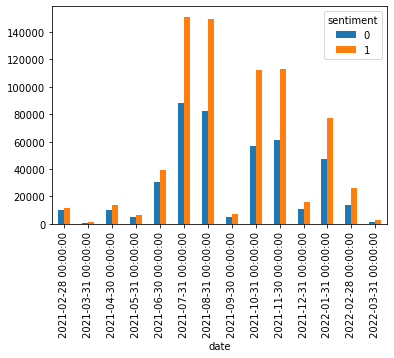

In [12]:
df_tweets['sentiment'].groupby(pd.Grouper(freq="M")).value_counts().unstack().plot(kind="bar")

https://www.kaggle.com/utkarshxy/stock-markettweets-lexicon-data

https://www.kaggle.com/saurabhshahane/twitter-sentiment-dataset


## Bitcoin Historical Data from Yahoo Finance


In [20]:
import zipfile
import os
import pandas as pd
import numpy as np
csv_file =  os.getcwd() + "\\Data\\BTC-USD.csv"

# Read from title file
price_df = pd.read_csv(csv_file)

# Date
price_df['date'] = pd.to_datetime(price_df['date']) 
price_df = price_df.set_index(pd.DatetimeIndex(price_df['date']))

# On our Bitcoin data, we have a column ‘Close’ with the closing price of the day and ‘Open’ with the opening price of the day. 
# We want to get the percentage difference from the closing price with respect to the opening price so we have a variable with that day’s performance. 
# To get this variable we will calculate the logarithmic difference between the close and open price.
price_df['log_diff'] = np.log(price_df['close']) - np.log(price_df['open'])

# Generate our target variable by setting “1” if the performance was positive (log_diff > 0) and “0” if else.
price_df['target'] = [1 if log_diff > 0 else 0 for log_diff in price_df['log_diff']]

# Remove unrequired columns
price_df.drop(columns=['high','low','adj close','volume','date','log_diff'], inplace=True)

# Save 
price_df.columns = map(str.lower, price_df.columns)
price_df.to_csv(os.getcwd() + '\\Data\\formatted_bitcoin_price.csv')
price_df


,open,close,target
date,,,
2021-02-10,46469.761719,44918.183594,0
2021-02-11,44898.710938,47909.332031,1
2021-02-12,47877.035156,47504.851563,0
2021-02-13,47491.203125,47105.515625,0
2021-02-14,47114.507813,48717.289063,1
...,...,...,...
2022-02-26,39213.082031,39105.148438,0
2022-02-27,39098.699219,37709.785156,0
2022-02-28,37706.000000,43193.234375,1
